In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

import global_params as G
plt.rcParams['figure.figsize'] = G.SMALL_FIG

In [3]:
import numpy as np
from scipy import signal
from scipy.fftpack import fft

np.set_printoptions(precision=4, suppress=True)

In [13]:
from transmitter import *
from receiver import *
from freq_domain import plotspec

## Section 9.1

### Transmitter design

In [6]:
msg = '01234 I wish I were an Oscar Meyer wiener 56789'

<IPython.core.display.Javascript object>


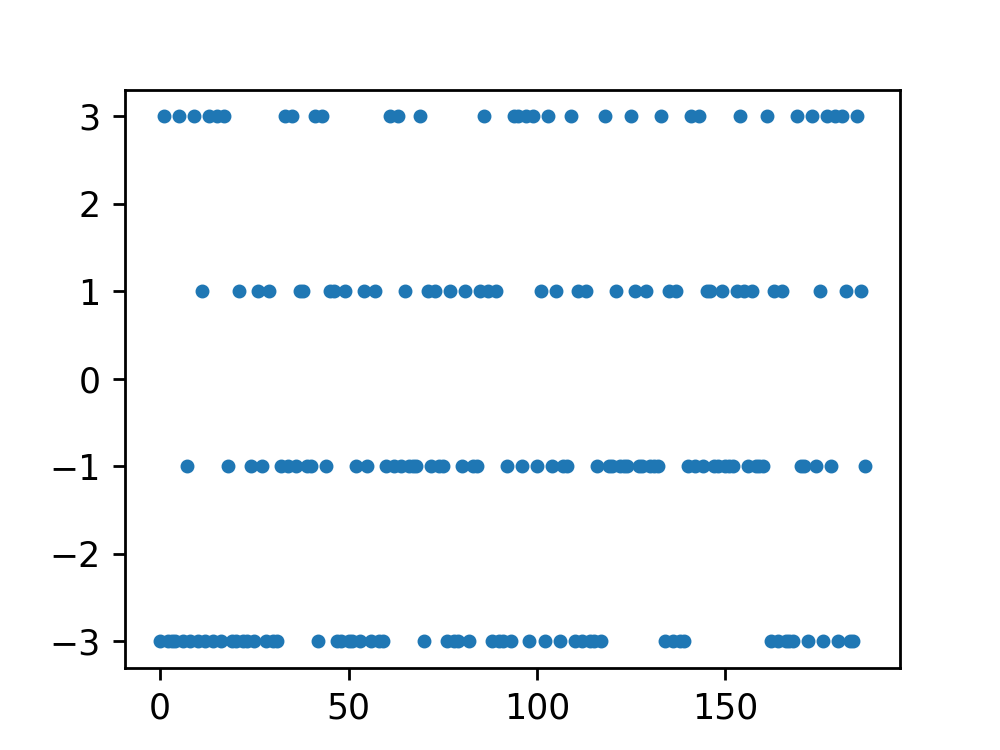

In [9]:
# Convert to PAM symbols
symbols = letters2pam(msg)
plt.plot(symbols, '.');

<IPython.core.display.Javascript object>


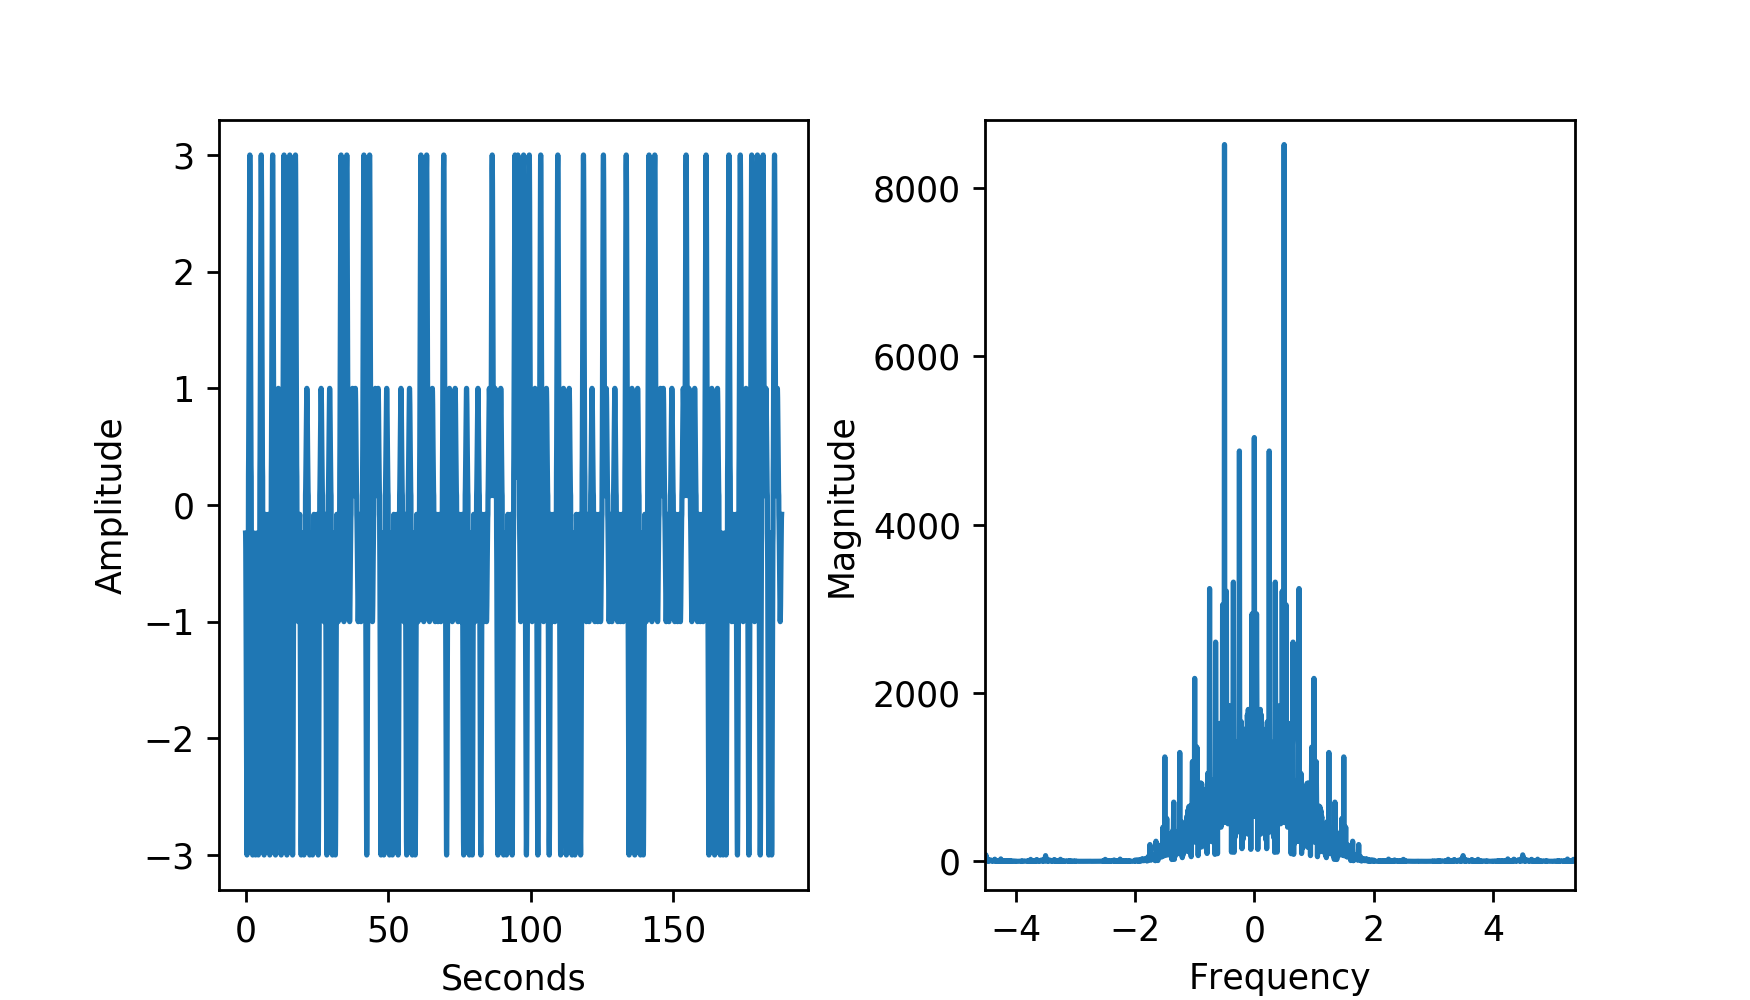

In [15]:
# Pulse shaping with a hamming pulse
M = 100 # oversampling factor
analog_waveform = pulse_shaped(symbols, M)
plotspec(analog_waveform, 1/M);

<IPython.core.display.Javascript object>


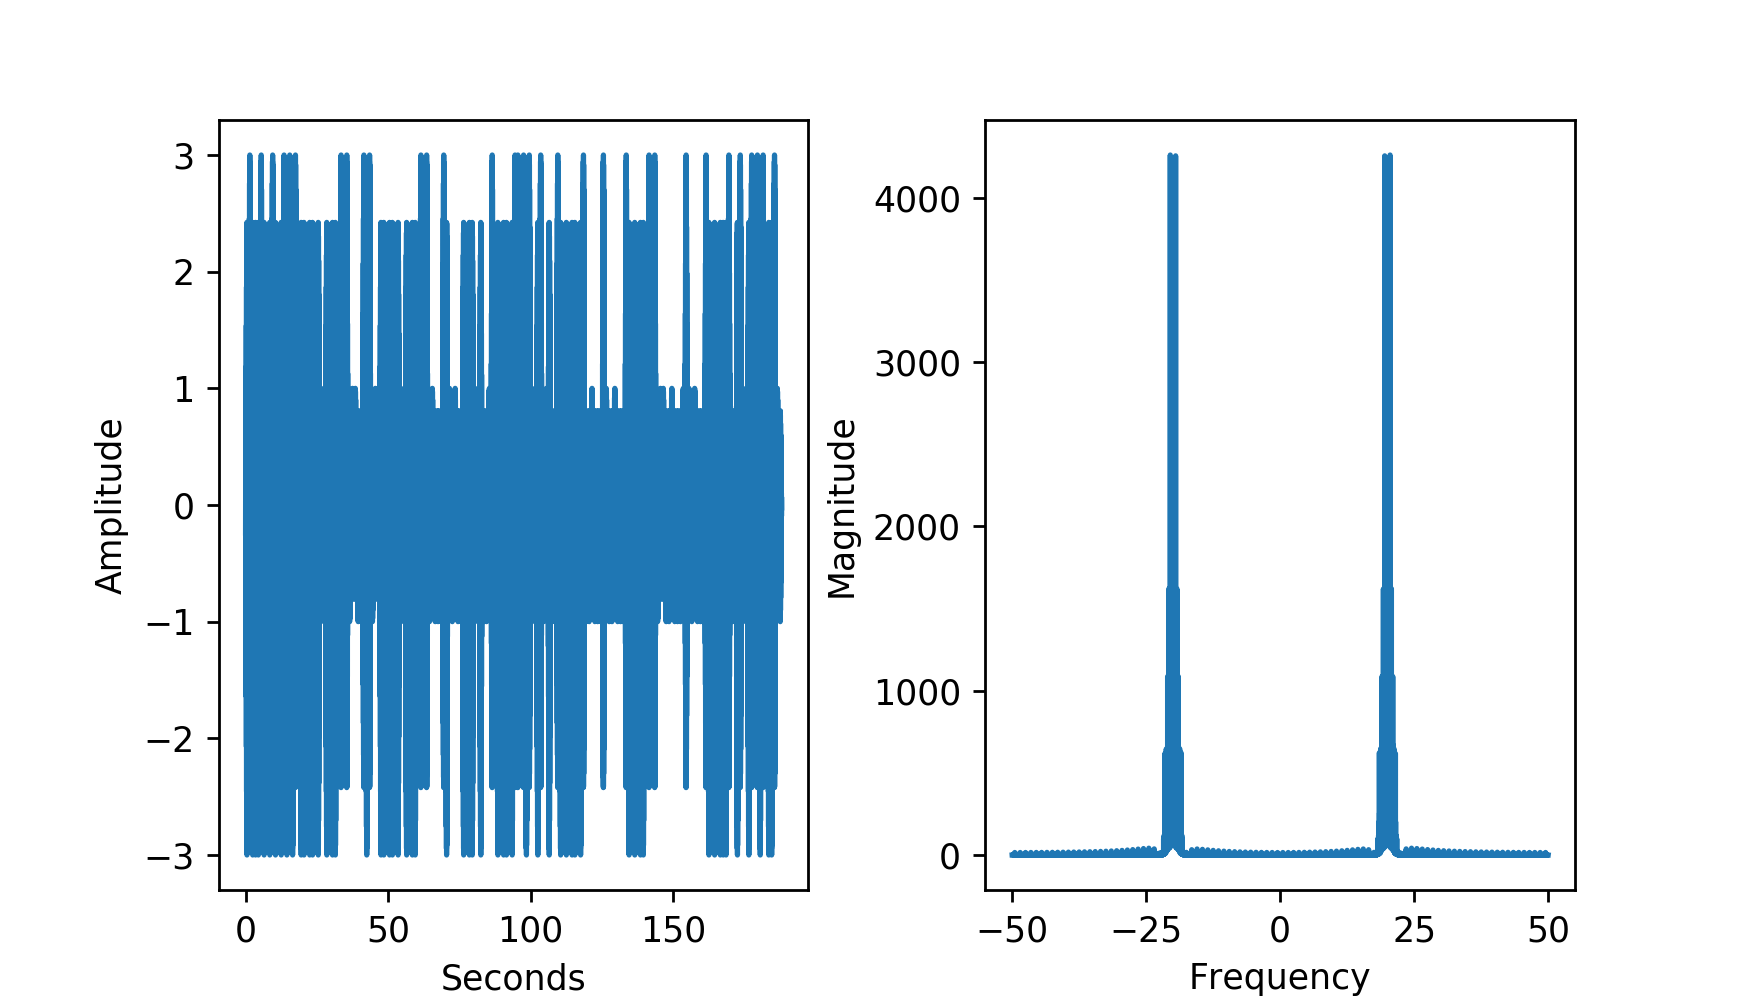

In [16]:
fc = 20
t, transmitted = modulate(analog_waveform, fc, 1/M)
plotspec(transmitted, 1/M);

In [ ]:
_, chck = ideal_transmitter(ms)

In [ ]:
plt.close('all')